Recently, I've come across the term Verlet integration several times: an [interesting numerical exploration of a moon explosion by Jason Cole](https://jasmcole.com/2017/09/20/the-moon-blew-up-without-warning-and-for-no-apparent-reason/) and the [wonderful Lennard-Jones molecular dynamics simulator by Daniel Schroeder](http://physics.weber.edu/schroeder/md/). I've been interested in numerical simulation for a long time (and wrote about it [here](http://flothesof.github.io/harmonic-oscillator-three-methods-solution.html) regarding the harmonic oscillator as well as [here](http://flothesof.github.io/charged-particle-trajectories-E-and-B-fields.html) regarding the movement of charged particles in E and B fields) so I think it's time to explore what exactly this numerical ODE integration technique is.

# Verlet integration 

According to [Wikipedia](https://en.wikipedia.org/wiki/Verlet_integration), Verlet integration is named after [Loup Verlet](https://en.wikipedia.org/wiki/Loup_Verlet), a French physicist who published [a paper in 1967 about a model of the Argon gas using 864 particles](https://journals.aps.org/pr/abstract/10.1103/PhysRev.159.98) following forces obeying the Lennard-Jones potential. The integration method that he used in the original paper is written as follows:

$$
\vec{r}_i (t+h) = -\vec{r}_i(t-h)  + 2 \vec{r}_i (t) + \sum_{j \neq i} \vec{f}(r_{ij}(t)) h^2
$$

For our purpose, we will use the formulation found in Wikipedia:
$$
\vec{r}_i (t+h) = -\vec{r}_i(t-h)  + 2 \vec{r}_i (t) + \vec{a}(r_{i}(t)) h^2
$$

In this equation, $\vec{r}$ is the position vector for the particle we are modeling and $\vec{a}$ is its acceleartion.

As stated in the Wikipedia article, the interesting thing about this integration scheme is that it is an order more accurate than integration by simple Taylor expansion alone and that is does not use the velocity vector at all. For me, this is quite surprising since most numerical integration techniques I have used before integrate acceleration to get velocity and integrate velocity to get positions.

This is all the theory we need. As we will see in the remainder of this post, this formulation is very general and will allow us to play with many examples: oscillators, particle systems, pendulums and many more.

# Applications

## Harmonic oscillator

Let's start with the harmonic oscillator since it is a good scalar example. The harmonic oscillator's  equation is: 
$$
\ddot{x} + \omega_0^2 x = 0
$$

Therefore, the scalar acceleration $a$ is computed as $-\omega_0^2 x$.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
class VerletSolver:
    def __init__(self, dt, x0, xd0, acc_func):
        "Inits the solver."
        self.dt = dt
        self.dt_squared = dt**2
        self.t = dt
        self.acc_func = acc_func
        self.x0 = x0
        self.xd0 = xd0
        # the second position vector is obtained by double integration of acceleration
        # using the initial velocity xd0
        x1 = acc_func(x0) * dt**2 / 2. + xd0 * dt + x0
        self.x = [x1, x0]
        
    def step(self):
        "Steps the solver."
        xt, xtm1 = self.x
        xtp1 = - xtm1 + 2 * xt + self.acc_func(xt) * self.dt_squared
        self.x = (xtp1, xt)
        self.t += self.dt
        
    def step_until(self, tmax, snapshot_dt):
        "Steps the solver until a given time, returns snapshots."
        ts = [self.t]
        vals = [self.x[0]]
        niter = max(1, int(snapshot_dt // self.dt))
        while self.t < tmax:
            for _ in range(niter):
                self.step()
            vals.append(self.x[0])
            ts.append(self.t)
        return np.array(ts), np.array(vals)

In [ ]:
def acc_func_harmonic(x):
    """Acceleration for harmonic oscilator."""
    omega_0 = 1.
    return -omega_0 * x

In [ ]:
solver = VerletSolver(0.01, 2, -0.01, acc_func_harmonic)

In [ ]:
ts, vals = solver.step_until(12, snapshot_dt=0.1)

In [ ]:
plt.plot(ts, vals, '-o')

Let's see how "stable" this is if we vary the integration step size.

In [ ]:
for step_size in [0.001, 0.01, 0.05, 0.25]:
    solver = VerletSolver(step_size, 2, -0.01, acc_func=acc_func_harmonic)
    ts, vals = solver.step_until(12, snapshot_dt=0.5)
    plt.plot(ts, vals, "-o", label='step_size: {}'.format(step_size))
plt.legend()
plt.ylim(-2.1, 2.1);

As the above graph shows, the Verlet integration works very well in this case.

## A two-dimensional spring 

Let's move on to a two-dimensional spring. The difference with the previous example is that the spring is described by a vector instead of a scalar: its position depends on two coordinates. This integrates easily with the vector Verlet update equation that was explained in the theory section.

This time, we thus use a 2d NumPy array to store initial positions and velocities `x0`, `xd0`.

One more thing we need is the description of the behavior of a spring. To quote H-P Langtangen:

> Stretching the elastic wire a distance ΔL gives rise to a spring force kΔL in the opposite direction of the stretching.

This is what we implement below:

In [ ]:
def acc_func_spring(x):
    """Acceleration for a 2D spring."""
    k = 10
    stretch = np.linalg.norm(x) 
    n = x / np.linalg.norm(x)
    acc = -  k * stretch * n
    return acc

Now, let's define initial conditions with a position and a speed and then run the simulation

In [ ]:
x0 = np.array([0, -1], dtype=np.float)
xd0 = np.array([0.0, 0.1], dtype=np.float)

In [ ]:
spring = VerletSolver(0.01, x0, xd0, acc_func_spring)

In [ ]:
ts, vals = spring.step_until(12, snapshot_dt=0.1)

In [ ]:
plt.plot(vals[:, 0], vals[:, 1])
plt.axis('equal');

Let's plot the trajectory according to time:

In [ ]:
plt.plot(ts, vals[:, 0])
plt.plot(ts, vals[:, 1])

Or as a frame-by-frame animation:

In [43]:
from IPython.display import HTML
import matplotlib.animation as mpl_anim

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 50
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    ax.plot(vals[index, 0], vals[index, 1], 'o')
    ax.plot(vals[index-5:index+1, 0], vals[index-5:index+1, 1], '-')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

If we give the spring a slight nudge to the right, we can get elliptical oscillations:

In [ ]:
xd0 = np.array([-0.5, .1], dtype=np.float)

In [ ]:
spring = VerletSolver(0.1, x0, xd0, acc_func_spring)

In [ ]:
ts, vals = spring.step_until(12, snapshot_dt=0.1)

In [ ]:
plt.plot(vals[:, 0], vals[:, 1])
plt.axis('equal');

Let's plot the trajectory according to time:

In [ ]:
plt.plot(ts, vals[:, 0])
plt.plot(ts, vals[:, 1])

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 50
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    ax.plot(vals[index, 0], vals[index, 1], 'o')
    ax.plot(vals[index-5:index+1, 0], vals[index-5:index+1, 1], '-')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

## Shooting a cannonball 

In [ ]:
def acc_func_cannonball(x):
    """Force function for a cannonball."""
    g = 10.
    acc = g * np.array([0., -1.])
    return acc

In [ ]:
x0 = np.array([0, 0], dtype=np.float)
xd0 = np.array([10.0, 10.0], dtype=np.float)

In [ ]:
cannonball = VerletSolver(0.001, x0, xd0, acc_func_cannonball)

In [ ]:
ts, vals = cannonball.step_until(2, snapshot_dt=0.1)

In [ ]:
plt.plot(vals[:, 0], vals[:, 1])
plt.axis('equal');

Let's plot the trajectory according to time:

In [ ]:
plt.plot(ts, vals[:, 0], label='x')
plt.plot(ts, vals[:, 1], label='y')
plt.legend();

Let's now fire a lot of cannonbals.

In [ ]:
for angle in np.deg2rad(np.linspace(0, 90, num=20)):
    x0 = np.array([0, 0], dtype=np.float)
    xd0 = 15 * np.array([np.cos(angle), np.sin(angle)], dtype=np.float)
    cannonball = VerletSolver(0.001, x0, xd0, acc_func_cannonball)
    ts, vals = cannonball.step_until(2, snapshot_dt=0.1)
    plt.plot(vals[:, 0], vals[:, 1], '-ok')
plt.axis('equal')
plt.axis([0, 20, 0, 7])

Let's do an animation of cannonball isochrones. We first precompute the trajectories:

In [ ]:
t_max = 3.5
trajectories = {}
angles = np.deg2rad(np.linspace(25, 85, num=20))
for angle in angles:
    x0 = np.array([0, 0], dtype=np.float)
    xd0 = 15 * np.array([np.cos(angle), np.sin(angle)], dtype=np.float)
    cannonball = VerletSolver(0.001, x0, xd0, acc_func_cannonball)
    ts, vals = cannonball.step_until(t_max, snapshot_dt=0.01)
    trajectories[angle] = (ts, vals)

And then animate the plot of the simultaneous trajectories as a function of time.

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 50
def animate(i):
    ax.clear() 
    for angle in angles:
        ts, vals = trajectories[angle]
        index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
        ax.plot(vals[:index, 0], vals[:index, 1], '-k')
        ax.plot(vals[index, 0], vals[index, 1], 'ok')
    ax.set_title(f"t = {ts[index]:.2f}")
    ax.set_xlim(-1, 19)
    ax.set_ylim(0, 20)
animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

## Asteroids around the earth 

We can also simulate some asteroids orbiting around the earth (considered fixed).

First, we generate a set of asteroids as well as their velocities.

In [ ]:
def make_asteroids(n, rmin, rmax):
    """Creates a bunch of asteroids."""
    rs = np.random.uniform(rmin, rmax, size=n) 
    thetas = np.random.uniform(0, 360, size=n)
    x = np.stack([rs * np.cos(thetas), rs * np.sin(thetas)], axis=1)
    n = np.stack([rs * np.sin(thetas), -rs * np.cos(thetas)], axis=1)
    xd = n 
    return x, xd

In [ ]:
x0, xd0 = make_asteroids(200, 0.5, 1.1)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(x0[:, 0], x0[:, 1], xd0[:, 0], xd0[:, 1])
ax.plot([0], [0], 'ro', ms=10, label='earth')
ax.legend()

We then create a plotting function:

In [ ]:
def plot_asteroids(x, ax, **plot_kwargs):
    xy = x.reshape(-1, 2)
    ax.plot(xy[:, 0], xy[:, 1], 'o', **plot_kwargs)
    ax.plot([0], [0], 'ro', ms=10, label='earth')

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_asteroids(x0, ax, ms=4, alpha=0.5)
ax.legend()

And now define the gravitational force, which always pulls the asteroids towards the earth.

In [ ]:
def acc_func_asteroids(x):
    """Acceleration for asteroids orbiting the earth."""
    xy = x.reshape(-1, 2)
    r = np.linalg.norm(xy - np.array([0., 0.]), axis=1)
    n = xy / r[:, np.newaxis]
    acc = - 0.0000001 * 1/r[:, np.newaxis]**2  * n
    return acc.ravel()

In [ ]:
asteroid_field = VerletSolver(1., 
                              x0.ravel(), 
                              (xd0.ravel() + np.random.randn(xd0.size) / 20) / 2000, 
                              acc_func_asteroids)
ts, vals = asteroid_field.step_until(40000, 100)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 100
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    plot_asteroids(vals[index], ax)
    if index>4:
        plot_asteroids(vals[index-1], ax, alpha=0.5, ms=5)
        plot_asteroids(vals[index-2], ax, alpha=0.4, ms=4)
        plot_asteroids(vals[index-3], ax, alpha=0.3, ms=3)
        plot_asteroids(vals[index-4], ax, alpha=0.2, ms=2)
    ax.axis([-2.5, 2.5, -2.5, 2.5])
    ax.legend(loc='upper right')
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=200, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

Let's also render a close-up view:

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 100
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    plot_asteroids(vals[index], ax)
    if index>4:
        plot_asteroids(vals[index-1], ax, alpha=0.5, ms=5)
        plot_asteroids(vals[index-2], ax, alpha=0.4, ms=4)
        plot_asteroids(vals[index-3], ax, alpha=0.3, ms=3)
        plot_asteroids(vals[index-4], ax, alpha=0.2, ms=2)
    ax.axis([-1.25, 1.25, -1.25, 1.25])
    ax.legend(loc='upper right')
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=200, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

As one can see, it seems that particles closer to the earth have faster orbits, while particles more farther away go more slowly.

## A pendulum 

Let's now turn to pendulums. A pendulum is basically a spring with an additional force: the pull of gravity along the vertical axis. Let's write that as a function:

In [ ]:
def acc_func_pendulum(x):
    """Force function with spring of fixed size."""
    g = 1.
    l0 = 1.
    elongation = np.linalg.norm(x) - l0
    k = 100.
    acc = - k * elongation * x / np.linalg.norm(x) + g * np.array([0, -1])
    return acc

In [ ]:
x0 = np.array([1, 0], dtype=np.float)
xd0 = np.array([0.0, 0.0], dtype=np.float)
pendulum = VerletSolver(0.01, x0, xd0, acc_func_pendulum)

In [ ]:
ts, vals = pendulum.step_until(15, snapshot_dt=0.05)

In [ ]:
plt.plot(vals[:, 0], vals[:, 1])
plt.axis('equal');

Let's plot the trajectory according to time:

In [ ]:
plt.plot(ts, vals[:, 0], label='x')
plt.plot(ts, vals[:, 1], label='y')
plt.legend();

Or as an animation:

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 50
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    ax.plot([0, vals[index, 0]], [0, vals[index, 1]])
    ax.plot(vals[index, 0], vals[index, 1], 'o')
    ax.plot(vals[index-10:index+1, 0], vals[index-10:index+1, 1], '-')
    ax.axis('equal')
    ax.axis([-1.5, 1.5, -2, 1])
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

One interesting thing about pendulums is that when you make the spring less stiff, you can obtain more varied behaviours:

In [ ]:
def acc_func_pendulum_elastic(x):
    """Force function with spring of fixed size."""
    g = 1.
    l0 = 1.
    elongation = np.linalg.norm(x) - l0
    k = 5.
    acc = - k * elongation * x / np.linalg.norm(x) + g * np.array([0, -1])
    return acc

In [ ]:
x0 = np.array([1, 0], dtype=np.float)
xd0 = np.array([0.0, 0.0], dtype=np.float)

pendulum = VerletSolver(0.01, x0, xd0, acc_func_pendulum_elastic)

ts, vals = pendulum.step_until(30, snapshot_dt=0.1)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 50
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    ax.plot([0, vals[index, 0]], [0, vals[index, 1]])
    ax.plot(vals[index, 0], vals[index, 1], 'o')
    ax.plot(vals[index-10:index+1, 0], vals[index-10:index+1, 1], '-')
    ax.axis('equal')
    ax.axis([-1.5, 1.5, -2, 1])
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

## Two particle systems

Another interesting example consists of two particles attached by a spring.

In [ ]:
def acc_func_two_spring(x):
    """Force function with spring of fixed size."""
    g = 1.
    l0 = 1.
    x1 = x[:2]
    x2 = x[2:]
    elongation1 = np.linalg.norm(x1 - x2) - l0
    elongation2 = np.linalg.norm(x2 - x1) - l0
    k = 10.
    acc = np.zeros_like(x)
    acc[:2] = - k * elongation1 * (x1 - x2) / np.linalg.norm(x1 - x2)
    acc[2:] = - k * elongation2 * (x2 - x1) / np.linalg.norm(x2 - x1)
    return acc

In [ ]:
x0 = np.array([0.75, 0, -0.75, 0], dtype=np.float)
xd0 = np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float)
twosprings = VerletSolver(0.01, x0, xd0, acc_func_two_spring)
ts, vals = twosprings.step_until(2.8, snapshot_dt=0.05)

Let's plot the trajectory according to time:

In [ ]:
plt.plot(ts, vals[:, 0], label='x')
plt.plot(ts, vals[:, 1], label='y')
plt.legend();

Let's animate this.

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 50
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    ax.plot(vals[index, [0, 2]], vals[index, [1, 3]], 'o', ms=50)
    ax.axis('equal')
    ax.axis([-1.5, 1.5, -1, 1])
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

What happens if the particles start with a little spin?

In [ ]:
x0 = np.array([0.75, 0, -0.75, 0], dtype=np.float)
xd0 = np.array([0.0, 0.1, 0.0, -.1], dtype=np.float)
twosprings = VerletSolver(0.01, x0, xd0, acc_func_two_spring)
ts, vals = twosprings.step_until(8, snapshot_dt=0.05)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 50
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    ax.plot(vals[index, [0, 2]], vals[index, [1, 3]], 'o')
    # tail 1
    ax.plot(vals[0:index+1, 0], vals[0:index+1, 1], '-')
    # tail 2
    ax.plot(vals[0:index+1, 2], vals[0:index+1, 3], '-')
    ax.axis('equal')
    ax.axis([-1.5, 1.5, -1, 1])
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

They still pull on each other, however the two particles now also "dance in a circle" following their initial momentum.

## A chain of oscillators strung together 

Let's build a chain of oscillators that are fixed on both ends.

In [ ]:
def build_chain(n_free):
    """Returns x0 and xd0 for a chain of n_free horizontal particles."""
    l0 = 1
    xs = np.arange(n_free + 2, dtype=np.float) * l0
    ys = np.zeros_like(xs)
    x0 = np.c_[xs.reshape(-1, 1), ys.reshape(-1, 1)].ravel()
    xd0 = np.zeros_like(x0) 
    return x0, xd0

In [ ]:
from matplotlib.collections import LineCollection

def plot_chain(ax, x):
    xy = x.reshape(-1, 2)
    line = LineCollection([[start, stop] for start, stop in zip(xy[:-1,:], xy[1:,:])], linestyles='-.')
    ax.add_artist(line)
    ax.plot(xy[:, 0], xy[:, 1], 'o')

In [ ]:
x0, xd0 = build_chain(3)
x0[4] += 50 / 100

In [ ]:
fig, ax = plt.subplots()
plot_chain(ax, x0)

Now, let's write the acceleration function.

In [ ]:
def acc_func_chain(x):
    """Acceleration of a chain of oscillators strung together. 
    Node 0 and -1 are assumed fixed."""
    k = 10.
    l0 = 1
    xy = x.reshape(-1, 2)
    acc = np.zeros_like(xy)
    for index in range(1, xy.shape[0] - 1):
        x0 = xy[index-1, :]
        x1 = xy[index, :]
        x2 = xy[index+1, :]
        
        elongation1 = (np.linalg.norm(x1 - x0) - l0) / l0
        elongation2 = (np.linalg.norm(x2 - x1) - l0) / l0
        acc[index, :] = - k * elongation1 * (x1 - x0) / np.linalg.norm(x1 - x0) \
                        - k * elongation2 * (x1 - x2) / np.linalg.norm(x2 - x1)
    
    return acc.ravel()

And now let's test this:

In [ ]:
chain = VerletSolver(0.01, x0, xd0, acc_func_chain)
ts, vals = chain.step_until(5, 0.1)

Let's see what the trajectories of the individual particles are like:

In [ ]:
fig, ax = plt.subplots()
reshaped_vals = vals.reshape(-1, 5, 2)
for particle_index in range(reshaped_vals.shape[1]):
    traj = reshaped_vals[:, particle_index, :]
    ax.plot(traj[:, 0])
    ax.plot(traj[:, 1])

Let's animate this:

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 50
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    plot_chain(ax, vals[index])
    ax.axis('equal')
    ax.axis([-0.5, 4.5, -0.1, 0.1])
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

What if one of the extremities is loose? This is just a matter of updating the acceleration of the last particle in the chain with the pulling of its neighbor.

In [ ]:
def acc_func_chain2(x):
    """Acceleration of a chain of oscillators strung together. 
    Node 0 and -1 are assumed fixed."""
    k = 10.
    l0 = 1
    xy = x.reshape(-1, 2)
    acc = np.zeros_like(xy)
    for index in range(1, xy.shape[0] - 1):
        x0 = xy[index-1, :]
        x1 = xy[index, :]
        x2 = xy[index+1, :]
        
        elongation1 = (np.linalg.norm(x1 - x0) - l0) / l0
        elongation2 = (np.linalg.norm(x2 - x1) - l0) / l0
        acc[index, :] = - k * elongation1 * (x1 - x0) / np.linalg.norm(x1 - x0) \
                        - k * elongation2 * (x1 - x2) / np.linalg.norm(x2 - x1)
    index += 1
    x0 = xy[index-1, :]
    x1 = xy[index, :]
    elongation1 = (np.linalg.norm(x1 - x0) - l0) / l0
    acc[index, :] = - k * elongation1 * (x1 - x0) / np.linalg.norm(x1 - x0) \
    
    return acc.ravel()

In [ ]:
x0, xd0 = build_chain(3)
x0[4] += 50 / 100
chain = VerletSolver(0.01, x0, xd0, acc_func_chain2)
ts, vals = chain.step_until(5, 0.1)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 50
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    plot_chain(ax, vals[index])
    ax.axis('equal')
    ax.axis([-0.5, 4.5, -0.1, 0.1])
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

What if we add a little bit of noise to this chain of oscilators?

In [ ]:
xd1 = xd0.copy()
xd1[2:] += np.random.randn(8) / 100
chain = VerletSolver(0.01, x0, xd1, acc_func_chain2)
ts, vals = chain.step_until(40, 0.1)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 50
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    plot_chain(ax, vals[index])
    ax.axis('equal')
    ax.axis([-4.5, 4.5, -0.1, 0.1])
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

We get a behaviour that resembles that of a N-link pendulum!

What if we use more than 5 particles?

In [ ]:
x0, xd0 = build_chain(28)
x0[-2] += .5
chain = VerletSolver(0.01, x0, xd0, acc_func_chain2)
ts, vals = chain.step_until(40, 0.1)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

FRAMES = 50
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    plot_chain(ax, vals[index])
    ax.axis([-0.5, 30.5, -0.1, 0.1])
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

Compression waves appear! Let's plot this data in the "earth science style" to see the wave advancing across time and space at the same time.

In [ ]:
fig, ax = plt.subplots(figsize=(5, 8))
reshaped_vals = vals.reshape(-1, 30, 2)
for time_index in range(0, reshaped_vals.shape[0], 10):
    delta_traj = reshaped_vals[time_index, :, 0] - np.arange(30)
    ax.plot(delta_traj - time_index / 40, 'k')
ax.axis('off');

What we see in the above graph is a double reflexion on the left side of the particle chain, as well as the physical phenomenon of dispersion: the wave started as a sharp peak but ended up as a diffuse velocity field.

## 2D waves in a lattice 

We can of course extend this sort of chaining to a grid. Let's first write a function that creates a grid of particles.

In [13]:
def build_grid(nx, ny):
    """Builds a grid of nx times ny nodes."""
    x = np.arange(nx, dtype=np.float)
    y = np.arange(ny, dtype=np.float)
    X, Y = np.meshgrid(x, y, indexing='ij')
    return X, Y

In [31]:
from numba import njit

In [25]:
@njit
def grid2linear(X, Y):
    """Returns a linear vector from a X,Y displacement representation."""
    return np.concatenate((X.ravel(), Y.ravel()))

In [26]:
@njit
def linear2grid(linear_repr, nx, ny):
    """Returns a grid X,Y displacement from a linear vector."""
    n = nx * ny
    X, Y = linear_repr[:n], linear_repr[n:2*n]
    X = X.reshape((nx, ny))
    Y = Y.reshape((nx, ny))
    return X, Y

Let's test these functions:

In [27]:
nx, ny = 3, 2
X, Y = build_grid(nx, ny)

In [28]:
print(X)
print(Y)

[[ 0.  0.]
 [ 1.  1.]
 [ 2.  2.]]
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


In [29]:
linear_repr = grid2linear(X, Y)
linear_repr

array([ 0.,  0.,  1.,  1.,  2.,  2.,  0.,  1.,  0.,  1.,  0.,  1.])

In [30]:
linear2grid(linear_repr, nx, ny)

(array([[ 0.,  0.],
        [ 1.,  1.],
        [ 2.,  2.]]), array([[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]]))

Let's now code the acceleration function, which will connect each node with its neighbors.

In [32]:
@njit
def acc_func_grid_template(x, nx, ny, k):
    """Acceleration of a grid of oscillators strung together to its 4 neighbors."""
    l0 = 1.
    l1 = np.sqrt(2)
    X, Y = linear2grid(x, nx, ny)
    acc_X, acc_Y = np.zeros_like(X), np.zeros_like(Y)
    for i in range(nx):
        for j in range(ny):
            x_center = np.array([X[i, j], Y[i, j]])
            for neighbor in [(i+1, j, l0), (i-1, j, l0),
                             (i, j+1, l0), (i, j-1, l0),
                             (i+1, j+1, l1), (i+1, j-1, l1),
                             (i-1, j+1, l1), (i-1, j-1, l1)]:
                ii, jj, l = neighbor
                if (ii >= 0 and ii < nx) and (jj >=0 and jj < ny):
                    x_neighb = np.array([X[ii, jj], Y[ii, jj]])
                    stretch = np.linalg.norm(x_center - x_neighb) - l
                    acc = - k * l0 / l * stretch * (x_center - x_neighb) / np.linalg.norm(x_center - x_neighb)
                    acc_X[i, j] += acc[0]
                    acc_Y[i, j] += acc[1]
    return grid2linear(acc_X, acc_Y)

In [33]:
from functools import partial

In [34]:
acc_func_grid = partial(acc_func_grid_template, nx=nx, ny=ny, k=20.)
acc_func_grid(linear_repr)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [35]:
linear_repr[1] += 0.1

In [36]:
acc_func_grid(linear_repr)

array([ 0.00992562, -2.66129819,  0.65137257,  2.        ,  0.        ,
        0.        ,  0.0992562 ,  0.62449111, -0.7237473 ,  0.        ,
        0.        ,  0.        ])

In [37]:
def plot_grid(x, nx, ny, ax=None):
    X, Y = linear2grid(x, nx, ny)
    if ax is None:
        ax = plt.gca()
    ax.scatter(X.ravel(), Y.ravel())

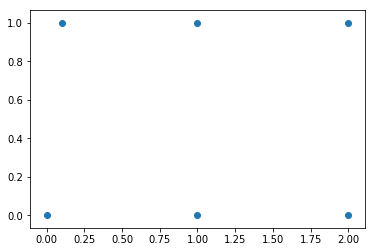

In [38]:
plot_grid(linear_repr, nx=nx, ny=ny)

Let's try this with some random noise.

In [54]:
nx, ny = 3, 3
X, Y = build_grid(nx, ny)
x0 = grid2linear(X, Y)
x0[1] += 0.3
xd0 = np.zeros_like(x0)
acc_func_grid = partial(acc_func_grid_template, nx=nx, ny=ny, k=10.)
grid = VerletSolver(0.01, x0, xd0, acc_func_grid)
ts, vals = grid.step_until(2.5, snapshot_dt=0.1)

In [55]:
acc_func_grid(x0)

array([ 0.12652114, -4.82279424,  0.12652114,  0.78487598,  3.        ,
        0.78487598,  0.        ,  0.        ,  0.        ,  0.42173715,
        0.        , -0.42173715, -1.12125139,  0.        ,  1.12125139,
        0.        ,  0.        ,  0.        ])

Let's now plot the grid of particles, between its initial and final state in the simulation. 

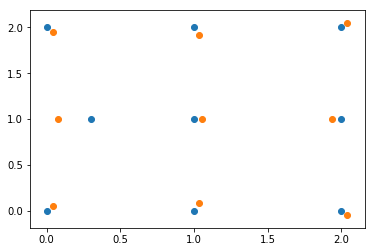

In [56]:
plot_grid(vals[0], nx, ny)
plot_grid(vals[-1], nx, ny)

In [57]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 50
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    plot_grid(vals[index], nx, ny, ax=ax)
    ax.set_title(f"t = {ts[index]:.2f}")
    ax.axis('off')

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

What if we give some of the particles a specific directional nudge? 

In [61]:
nx, ny = 11, 12
X, Y = build_grid(nx, ny)
x0 = grid2linear(X, Y)
x0[:ny] += 0.6
x0[nx*ny:nx*ny+ny] += 0.2
xd0 = np.zeros_like(x0)
acc_func_grid = partial(acc_func_grid_template, nx=nx, ny=ny, k=1.)
grid = VerletSolver(0.05, x0, xd0, acc_func_grid)
ts, vals = grid.step_until(20, snapshot_dt=0.05)

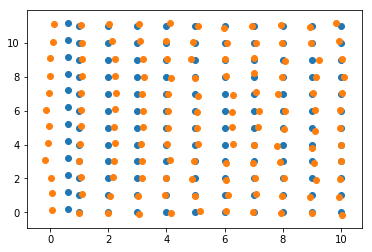

In [62]:
plot_grid(vals[0], nx, ny)
plot_grid(vals[-1], nx, ny)

In [64]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 40
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    plot_grid(vals[index], nx, ny, ax=ax)
    ax.set_title(f"t = {ts[index]:.2f}")
    ax.axis([-1, nx+1, -1, ny+1])
    ax.axis('off')

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

Another version might be to add random movements to the particles.

In [67]:
nx, ny = 11, 12
X, Y = build_grid(nx, ny)
x0 = grid2linear(X, Y)
x0 += np.random.randn(*x0.shape) / 10
xd0 = np.zeros_like(x0)
acc_func_grid = partial(acc_func_grid_template, nx=nx, ny=ny, k=1.)
grid = VerletSolver(0.05, x0, xd0, acc_func_grid)
ts, vals = grid.step_until(20, snapshot_dt=0.05)

In [68]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 40
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    plot_grid(vals[index], nx, ny, ax=ax)
    ax.set_title(f"t = {ts[index]:.2f}")
    ax.axis([-1, nx+1, -1, ny+1])
    ax.axis('off')

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)
HTML(animation.to_jshtml())

## Lennard Jones particles 

# Trying to mess with the png encoding in to_jshtml 

Simulating the spring.

In [320]:
x0 = np.array([0, -1], dtype=np.float)
xd0 = np.array([0.0, 0.1], dtype=np.float)
spring = VerletSolver(0.01, x0, xd0, acc_func_spring)
ts, vals = spring.step_until(12, snapshot_dt=0.1)

Making the animation.

In [321]:
fig, ax = plt.subplots(figsize=(5, 5))

FRAMES = 50
def animate(i):
    index = np.argmin((np.linspace(0, 1, vals.shape[0]) - i / FRAMES)**2)
    ax.clear()
    ax.plot(vals[index, 0], vals[index, 1], 'o')
    ax.plot(vals[index-5:index+1, 0], vals[index-5:index+1, 1], '-')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(f"t = {ts[index]:.2f}")

animation = mpl_anim.FuncAnimation(fig, animate, init_func=lambda: None,
                        frames=FRAMES, interval=100, blit=False)
plt.close(fig)

In [322]:
plt.rcParams['animation.html_args']

[]

In [323]:
plt.rcParams['animation.codec']

'h264'

In [324]:
HTML(animation.to_html5_video())

In [325]:
mpl_anim.HTMLWriter(fps=10, extra_args={'frame_format':'jpeg'})

In [326]:
mpl_anim.Animation.to_jshtml = mpl_anim

In [ ]:
import tempfile
HTMLWriter = mpl_anim.HTMLWriter
import os

def to_jshtml_jpeg(self, fps=None, embed_frames=True, default_mode=None):
    """Generate HTML representation of the animation"""
    if fps is None and hasattr(self, '_interval'):
        # Convert interval in ms to frames per second
        fps = 1000 / self._interval

    # If we're not given a default mode, choose one base on the value of
    # the repeat attribute
    if default_mode is None:
        default_mode = 'loop' if self.repeat else 'once'

    if hasattr(self, "_html_representation"):
        return self._html_representation
    else:
        # Can't open a second time while opened on windows. So we avoid
        # deleting when closed, and delete manually later.
        with tempfile.NamedTemporaryFile(suffix='.html',
                                         delete=False) as f:
            self.save(f.name, writer=HTMLWriter(fps=fps,
                                                embed_frames=embed_frames,
                                                default_mode=default_mode,
                                                extra_args={'frame_format':'jpeg'}))
        # Re-open and get content
        with open(f.name) as fobj:
            html = fobj.read()

        # Now we can delete
        os.remove(f.name)

        self._html_representation = html
    return html